In [1]:
# initialization
using DataFrames, PyPlot;

In [2]:
Pkg.clone("http://github.com/madeleineudell/LowRankModels.jl");

INFO: Cloning LowRankModels from http://github.com/madeleineudell/LowRankModels.jl


LoadError: LoadError: LowRankModels already exists
while loading In[2], in expression starting on line 1

In [3]:
using LowRankModels;

In [4]:
include("proxgrad.jl");

In [5]:
data = readtable("JuliaDataFile.csv");

In [6]:
# description of the dataset
for i in 1:size(data,2)
    println(string(names(data)[i], "\t\t", typeof(data[4,i]), "\t\t\t", data[4,i]))  
end

SHOT_CLOCK		Float64			10.9
DRIBBLES		Int64			2
TOUCH_TIME		Float64			2.7
SHOT_DIST		Float64			3.7
PTS_TYPE		Int64			2
CLOSE_DEF_DIST		Float64			1.1
FGM		Int64			0


In [7]:
function split(arr::Array)
    X = convert(Array{Float64}, arr[:,1:end-1])
    y = arr[:,end]
    y[:] = 2*y[:] - 1
    
    n = size(arr)[1]
    is = sortperm(rand(n))
    
    
    Xtrain = X[is[1:Int(4*round(n/5))],:] ## X training set
    Xtest = X[is[Int(4*round(n/5)+1):end],:] ## X test set
    ytrain = convert(Array{Int}, y[is[1:Int(4*round(n/5))]]) ## y training set
    ytest = convert(Array{Int}, y[is[Int(4*round(n/5)+1):end]]) ## y test set
    return X, y, Xtrain, Xtest, ytrain, ytest
end

split (generic function with 1 method)

In [8]:
# all shots
all = convert(Array{Float64}, data);
X, y, X_tr, X_te, y_tr, y_te = split(all);

In [9]:
# 2 pointers
twos_data = data[data[:PTS_TYPE] .== 2,:]
twos = convert(Array{Float64}, twos_data)
X_2s, y_2s, X_2s_tr, X_2s_te, y_2s_tr, y_2s_te = split(twos);

In [10]:
# 3 pointers
threes_data = data[data[:PTS_TYPE] .== 3,:]
threes = convert(Array{Float64}, threes_data)
X_3s, y_3s, X_3s_tr, X_3s_te, y_3s_tr, y_3s_te = split(threes);

# 1. try the perceptron

In [83]:
# try to make a function for this
function pltpercep(xc, yc, X, y)
    clf()
    hold(true)
    axis("off")
    n = size(X)[1]
    for i=1:n
        plot(X[i,xc], X[i,yc], y[i]==1 ? "bo" : "rd")
    end

    # set figure limits
    ylim([-1,maximum(X[:,yc]+1)])
    xlim([-1,maximum(X[:,xc]+1)])
    title("Perceptron Attempt")
end

pltpercep (generic function with 1 method)

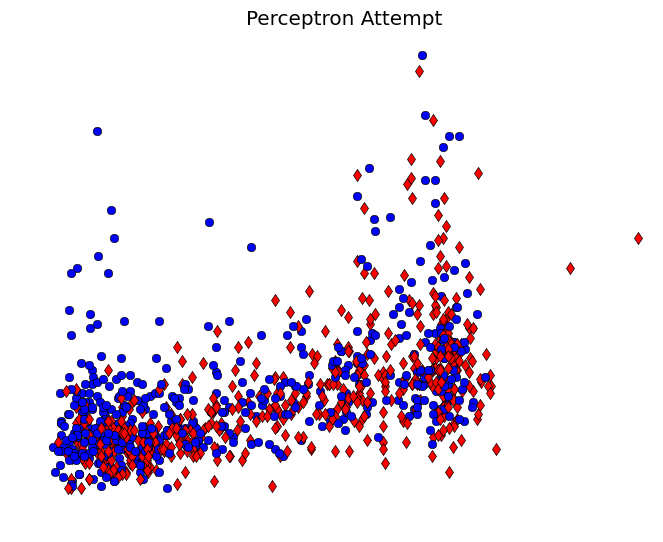

PyObject <matplotlib.text.Text object at 0x7f8e6b57ddd0>

In [84]:
# shot distance, and closest defender distance
pltpercep(4,6,X_tr[1:1000,:], y_tr[1:1000])

# 2. polynomial models

In [95]:
function fit_polynomial(xtrain::Array, xtest::Array, ytrain::Array, ytest::Array; max_order = 10)
    
    # create a w matrix 
    w_mat = zeros(Float64, max_order+1, max_order+1)
    
    # Vandermode matrix initalization
    X₁ = zeros(length(xtrain), max_order+1)
    for j = 0:max_order
        X₁[:,j+1] = xtrain.^j
    end

    mis = Array(Float64, max_order+1)

    # find the model with the lowest error on the test set
    for order = 0:max_order
        # Vandermode matrix subset  
        X = X₁[:,1:order+1]

        # Fit a model
        w= X\ytrain
        # @show w
        
        w_mat[order+1, 1:order+1] = w

        # Size of test set
        n_test = length(xtest)
        
        # Test the model on the test set
        predictions = zeros(n_test)
        for i in 1:n_test
            # compute the predicted make or miss for a shot clock
            prediction = 0
            for k = 0:order
                prediction += w[k+1]*xtest[i]^k
            end
            # prediction
            predictions[i] = sign(prediction) 
        end
        # calculate the  misclassification rate based on predictions[i] and ytrain
        mis[order+1] = 1- (sum(abs(predictions + ytest))/2) / n_test   
    end

    return w_mat, mis
end

fit_polynomial (generic function with 1 method)

In [99]:
# now create a function that takes in the first four and plots them 
function plotmodel(w, os)
    xmin, xmax = 0, 25
    ymin, ymax = -0.1, 0.5
    n = 100
    xs = linspace(xmin, xmax, n)
    ## os[i] is the order
    
    ## each order, ie order 1, 2, 3
    m = length(os)
    y = zeros(m,n)
    for i in 1:m
        order = os[i]
        for k = 1:n
            for j in 0:order
                y[i,k] += w[order+1,j+1]*xs[k]^j
            end
        end
    end
    xmin, xmax = 0, 25
    ymin, ymax = -0.1,1.25
    plot(xs,(y[3,:]+1)/2, color = "cyan", label = "3rd Best: Order $(os[3]) Model")
    plot(xs,(y[2,:]+1)/2, color = "red", label = "2nd Best: Order $(os[2]) Model")
    plot(xs,(y[1,:]+1)/2, color = "blue", label = "Best: Order $(os[1]) Model")
    legend()
    ylim([ymin, ymax])
    plot([xmin,xmax], [0,0], color = "black")
    plot([0,0], [ymin, ymax], color = "black")
end

plotmodel (generic function with 1 method)

### defender distance, all shots

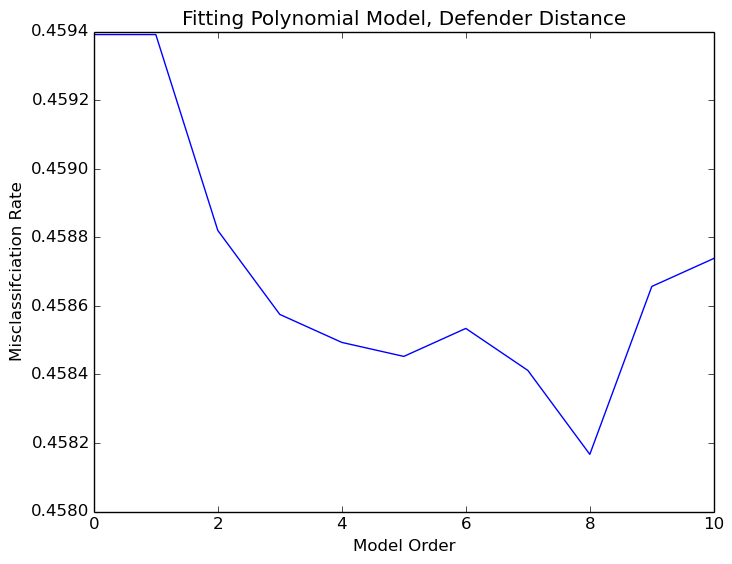

In [110]:
w_def, mis_def = fit_polynomial(X_tr[:,6], X_te[:,6], y_tr, y_te)
plot(mis_def)
xlabel("Model Order"); ylabel("Misclassifciation Rate"); title("Fitting Polynomial Model, Defender Distance")
order_def = (sortperm(mis_def).-1)[1:3] ## which has the lowest mse?;

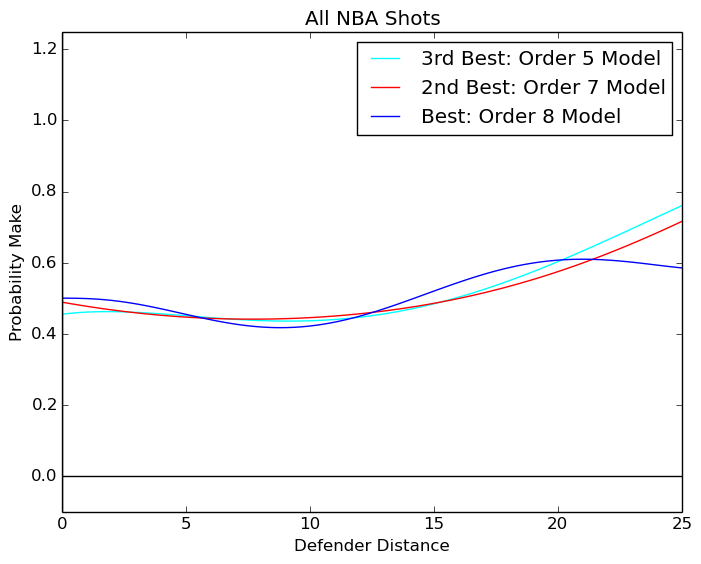

In [111]:
# plot the model
plotmodel(w_def, order_def)
xlabel("Defender Distance"); ylabel("Probability Make"); title("All NBA Shots");

### shot distance, all shots

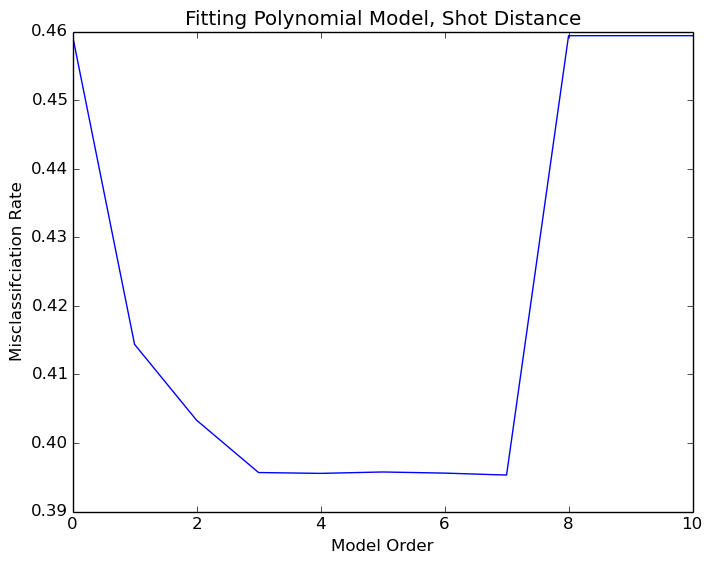

In [112]:
w_shot, mis_shot = fit_polynomial(X_tr[:,4], X_te[:,4], y_tr, y_te)
plot(mis_shot)
xlabel("Model Order"); ylabel("Misclassifciation Rate"); title("Fitting Polynomial Model, Shot Distance")
order_shot = (sortperm(mis_shot).-1)[1:3] ## which has the lowest mse?;

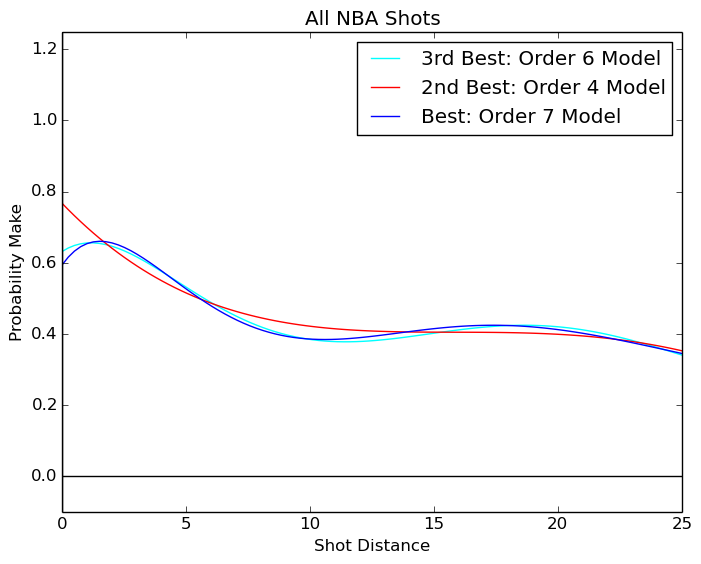

In [113]:
# plot the model
plotmodel(w_shot, order_shot)
xlabel("Shot Distance"); ylabel("Probability Make"); title("All NBA Shots");

### 3 point shots, defender distance

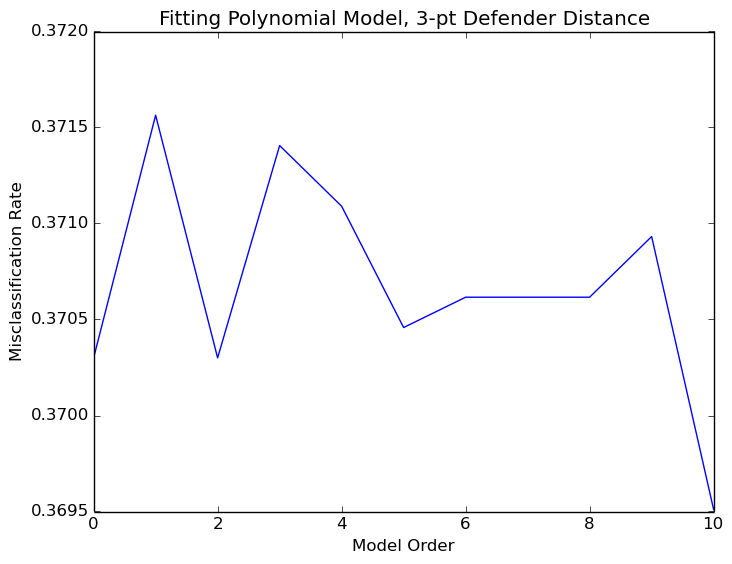

In [114]:
# 6th column is defender distance
w_def_3s, mis_def_3s = fit_polynomial(X_3s_tr[:,6], X_3s_te[:,6], y_3s_tr, y_3s_te)

plot(mis_def_3s)
xlabel("Model Order"); ylabel("Misclassification Rate"); title("Fitting Polynomial Model, 3-pt Defender Distance")
order_def_3s = (sortperm(mis_def_3s).-1)[2:4] ## which has the lowest mse?;

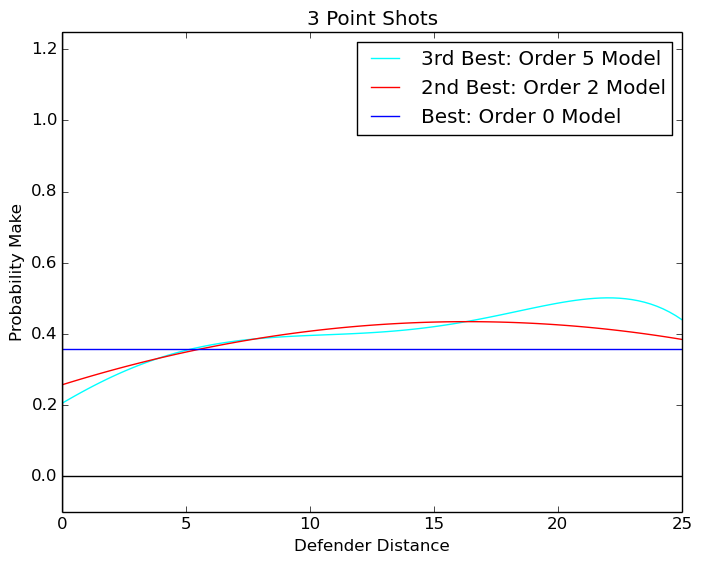

In [115]:
# plot the model
plotmodel(w_def_3s, order_def_3s)
xlabel("Defender Distance"); ylabel("Probability Make"); title("3 Point Shots");

# 3. Different loss functions and regularizers

In [13]:
n_train = size(X_tr)[1];

In [28]:
# fit least squares using backslash operator
w_lsq = X_tr \ y_tr

6-element Array{Float64,1}:
  0.00690912
  0.0103949 
 -0.0256816 
 -0.0296565 
  0.0382909 
  0.0452972 

In [18]:
# should be the same as above
ch_hinge_quad = ConvergenceHistory("Least Squares")
w_lsq_pg = proxgrad_linesearch(1/n_train*QuadLoss(), ZeroReg(), X_tr, y_tr; stepsize = 2, maxiters = 10000, ch = ch_hinge_quad)

6-element Array{Float64,1}:
  0.00690954
  0.0103938 
 -0.0256801 
 -0.0296561 
  0.0382847 
  0.0452975 

In [19]:
# logistic loss and no regularization
ch_log = ConvergenceHistory("Logistic")
w_log = proxgrad_linesearch(1/n_train*LogisticLoss(), ZeroReg(), X_tr, y_tr; stepsize = 2, maxiters = 10000, ch = ch_log)

6-element Array{Float64,1}:
  0.0145945
  0.023048 
 -0.05548  
 -0.0634462
  0.070716 
  0.104541 

In [20]:
# hinge loss and no regularization
ch_hinge = ConvergenceHistory("Hinge")
w_hinge = proxgrad_linesearch(1/n_train*HingeLoss(), ZeroReg(), X_tr, y_tr; stepsize = 2, maxiters = 10000, ch = ch_hinge)

6-element Array{Float64,1}:
  0.0118543
  0.0440827
 -0.0816622
 -0.10828  
  0.431635 
  0.0591435

In [21]:
# logistic loss with l1 regularization
ch_log_l1 = ConvergenceHistory("Logistic_l1")
w_log_l1 = proxgrad_linesearch(1/n_train*LogisticLoss(), OneReg(), X_tr, y_tr; stepsize = 2, maxiters = 10000, ch = ch_log_l1)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in max(::Array{Float64,1}, ::Int64) at ./deprecated.jl:50
 in prox(::LowRankModels.OneReg, ::Array{Float64,1}, ::Int64) at /home/juser/.julia/v0.6/LowRankModels/src/regularizers.jl:80
 in #proxgrad_linesearch#2(::Int64, ::Int64, ::Array{Float64,1}, ::LowRankModels.ConvergenceHistory, ::Function, ::LowRankModels.LogisticLoss, ::LowRankModels.OneReg, ::Array{Float64,2}, ::Array{Int64,1}) at /home/juser/Project/proxgrad.jl:48
 in (::#kw##proxgrad_linesearch)(::Array{Any,1}, ::#proxgrad_linesearch, ::LowRankModels.LogisticLoss, ::LowRankModels.OneReg, ::Array{Float64,2}, ::Array{Int64,1}) at ./<missing>:0
 in include_string(::String, ::String) at ./loading.jl:478
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.6/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.6/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:363
while loading In[21], in expre

6-element Array{Float64,1}:
  0.0       
  0.0       
  0.0       
 -0.00635445
  0.0       
  0.0       

In [22]:
# hinge loss with l1 regularization
ch_hinge_l1 = ConvergenceHistory("Hinge_l1")
w_hinge_l1 = proxgrad_linesearch(1/n_train*HingeLoss(), OneReg(), X_tr, y_tr; stepsize = 2, maxiters = 10000, ch = ch_hinge_l1)

6-element Array{Float64,1}:
  0.0      
  0.0      
  0.0      
 -0.0404858
  0.0      
  0.0      

In [16]:
# logistic and quadratic
ch_log_quad = ConvergenceHistory("Log_quad")
w_log_quad = proxgrad_linesearch(1/n_train*LogisticLoss(), QuadReg(), X_tr, y_tr; stepsize = 2, maxiters = 10000, ch = ch_log_quad)

6-element Array{Float64,1}:
  0.0207636 
 -0.00799842
 -0.0117627 
 -0.0412211 
  0.00179679
  0.0349893 

In [15]:
# hinge loss and quadratic regularization
ch_hinge_quad = ConvergenceHistory("Hinge_quad")
w_hinge_quad = proxgrad_linesearch(1/n_train*HingeLoss(), QuadReg(), X_tr, y_tr; stepsize = 1, maxiters = 10000, ch = ch_hinge_quad)

6-element Array{Float64,1}:
  0.0407263
 -0.0131305
 -0.019428 
 -0.0727893
  0.0197845
  0.0433301

### misclassification rate

In [32]:
# calculates the misclassification rate of a model
function misclassification(X, y, w)
    n = size(X,1)
    mis = 0
    for i in 1:n
        if(sign((w'*X[i,:])[1]) != y[i])
            mis += 1/n
        end
    end
    return round(mis, 4)
    #println("$(round(mis,4)*100) percent")
end

misclassification (generic function with 1 method)

In [34]:
misclassification(X_te, y_te, w_lsq) ## least squares

0.3992

In [35]:
misclassification(X_te, y_te, w_lsq_pg) ## least squares

0.3992

In [36]:
misclassification(X_te, y_te, w_log) ## logistic loss, no reg. 

0.4005

In [37]:
misclassification(X_te, y_te, w_hinge) ## hinge loss, no regularizer

0.4096

In [38]:
misclassification(X_te, y_te, w_log_l1) ## logistic loss, l1 reg.

0.4594

In [39]:
misclassification(X_te, y_te, w_hinge_l1) ## hinge loss, l1 reg. 

0.4594

In [40]:
misclassification(X_te, y_te, w_log_quad) ## log loss, quad reg. 

0.3991

In [41]:
misclassification(X_te, y_te, w_hinge_quad) ## hinge loss, quadratic reg.

0.4001